<a href="https://colab.research.google.com/github/deeplearning-itba/REINFORCE-Algorithm/blob/master/01_Monte_Carlo_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monte Carlo y Cálculo de Varianza

https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance

https://en.wikipedia.org/wiki/Monte_Carlo_method

# Importamos librerías y bajamos modeles pre-entrenados

In [2]:
# instalación de libreías y bajada de modelos
! pip install box2d-py
! wget https://github.com/deeplearning-itba/REINFORCE-Algorithm/raw/master/cartpole-trained.hdf5
! wget https://github.com/deeplearning-itba/REINFORCE-Algorithm/raw/master/lunar-lander-trained.hdf5
! wget https://raw.githubusercontent.com/deeplearning-itba/REINFORCE-Algorithm/master/REINFORCE_helper.py

--2019-11-27 17:38:31--  https://github.com/deeplearning-itba/REINFORCE-Algorithm/raw/master/cartpole-trained.hdf5
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/deeplearning-itba/REINFORCE-Algorithm/master/cartpole-trained.hdf5 [following]
--2019-11-27 17:38:31--  https://raw.githubusercontent.com/deeplearning-itba/REINFORCE-Algorithm/master/cartpole-trained.hdf5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33032 (32K) [application/octet-stream]
Saving to: ‘cartpole-trained.hdf5’

cartpole-trained.hd 100%[===================>]  32.26K  --.-KB/s    in 0.007s  

2019-11-27 17:38:31 (4.48 MB/s)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from REINFORCE_helper import RunningVariance

Using TensorFlow backend.


# Entornos de OpenAI

Vamos a usar dos entornos: CartPole-v1 y LunarLander-v2.

Instanción entorno y realizar las pruebas que se piden:

In [0]:
# Instanciamos los entornos.
env_cp = gym.make("CartPole-v1")
env_ll = gym.make("LunarLander-v2")

Usar las propiedades del entorno action_space y observation_space para responder las siguientes preguntas: 

¿Cúal es la dimensión del espacio de acción del CartPole?

¿Cúal es la dimensión del espacio de acción del LunarLander?

¿Cúal es la dimensión del espacio de observación del CartPole?

¿Cúal es la dimensión del espacio de observación del LunarLander?

In [51]:
# Ejecutar la siguiente celda y ver que devuelve
env_cp.seed()
env_cp.reset()

# ¿Que devuelve? ¿Siempre es el mismo resultado?

array([ 0.00645211,  0.015444  ,  0.00784133, -0.04185638])

In [57]:
# Ejecutar la siguiente celda y ver que devuelve
env_cp.seed(42)
env_cp.reset()

# ¿Que devuelve? ¿Siempre es el mismo resultado?

array([-0.01258566, -0.00156614,  0.04207708, -0.00180545])

In [0]:
# Para el CartPole
# Observation: 
#     Type: Box(4)
#     Num	Observation                 Min         Max
#     0	Cart Position             -4.8            4.8
#     1	Cart Velocity             -Inf            Inf
#     2	Pole Angle                 -24 deg        24 deg
#     3	Pole Velocity At Tip      -Inf            Inf
    
# Actions:
#     Type: Discrete(2)
#     Num	Action
#     0	Push cart to the left
#     1	Push cart to the right

In [0]:
# Para el LunarLander
# Coordinates are the first two numbers in state vector.
# Actions:
# Nop, fire left engine, main engine, right engine

# Implementar Monte carlo

Implementar función run_episode_with_random_policy con una politica aleatoria con distribución uniforme

In [0]:
def run_episode_with_random_policy(env, seed=42):
    done = False
    env.seed(seed)
    obs = env.reset()
    rewards = []
    observations = []
    actions = []
    while not done:
        action = np.random.randint(env.action_space.n)
        obs_, reward, done, _ = env.step(action)
        rewards.append(reward)
        observations.append(obs)
        actions.append(action)
        obs = obs_
    return observations, actions, rewards

In [0]:
observations, actions, rewards = run_episode_with_random_policy(env_cp)

Implementar funcion monte_carlo_with_random_policy

In [0]:
def monte_carlo_with_random_policy(env, seed=42, N=500):
  returns = []
  running_variance = RunningVariance()
  run_var = []
  run_mean = []
  return_with_baseline = []
  for i in range(N):
    print(f'\rEpisodio: {i}', end='')
    observations, actions, rewards = run_episode_with_random_policy(env, seed=seed)
    return_ = np.sum(rewards)
    running_variance.add(return_)
    run_var.append(running_variance.get_variance())
    run_mean.append(running_variance.get_mean())
    returns.append(return_)
  print()
  returns = np.array(returns)
  run_var = np.array(run_var)
  run_mean = np.array(run_mean)
  return run_mean, run_var, returns

In [86]:
monte_carlo_with_random_policy(env_cp)

Episodio: 0

AttributeError: ignored

In [0]:
def get_policy(env, hidden_layer_neurons = 128):
    output_shape = env.action_space.n
    input_shape = env.observation_space.shape
    model = Sequential()
    model.add(Dense(hidden_layer_neurons, input_shape=input_shape, activation='relu'))
    model.add(Dense(output_shape, activation='softmax'))
    return model

In [106]:
model = get_policy(env)
model.summary()
print(f'La dimensión de entrada de la red es {model.input.shape}')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               640       
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 258       
Total params: 898
Trainable params: 898
Non-trainable params: 0
_________________________________________________________________
La dimensión de entrada de la red es (?, 4)


In [0]:
def run_episode(env, model, seed=42, explore=True):
    done = False
    if seed>0:
        env.seed(seed)
    obs = env.reset()
    rewards = []
    observations = []
    actions = []
    while not done:
        actions_dist = model.predict_proba(obs.reshape(-1, env.observation_space.shape[0]))
        if explore:
            sampled_action = np.random.choice(range(env.action_space.n), p=actions_dist[0])
        else:
            sampled_action = np.argmax(actions_dist[0])
        obs_, reward, done, _ = env.step(sampled_action)
        rewards.append(reward)
        observations.append(obs)
        actions.append(sampled_action)
        obs = obs_
    return observations, actions, rewards

![alt text](https://drive.google.com/uc?export=view&id=1KDO01izeRAp6gkk5Mb12k3m3Knkzf8Ol)



In [0]:
def two_pass_variance(returns, epsilon=1e-12):
  mu_t = np.cumsum(returns)/(np.array(range(len(returns)))+1)
  sigmas = (returns - mu_t)**2
  sigma_t = np.cumsum(sigmas)/(np.array(range(len(returns)))+epsilon)
  return mu_t, sigma_t

In [0]:
def monte_carlo(env, model, seed=42, N=500, explore=True, k=20):
  returns = []
  running_variance = RunningVariance()
  run_var = []
  run_mean = []
  return_with_baseline = []
  for i in range(N):
    print(f'\rEpisodio: {i}', end='')
    observations, actions, rewards = run_episode(env, model, seed=seed, explore=explore)
    return_ = np.sum(rewards)
    running_variance.add(return_)
    run_var.append(running_variance.get_variance())
    run_mean.append(running_variance.m_k)
    returns.append(return_)
    return_with_baseline.append((return_-running_variance.m_k))
  print()
  returns = np.array(returns)
  mu_t, sigma_t =  two_pass_variance(return_with_baseline)
  return mu_t, sigma_t, run_mean, run_var, returns

In [128]:
%time estimated_V, variance_V, run_mean, run_var, returns = monte_carlo(env, model, seed=42, N=100)

Episodio: 99
CPU times: user 2.07 s, sys: 125 ms, total: 2.19 s
Wall time: 1.83 s


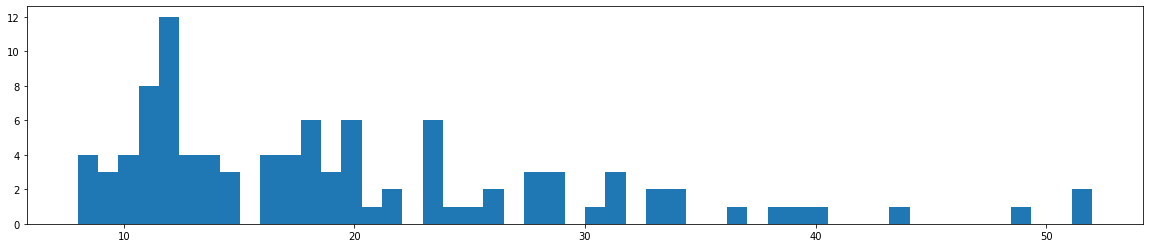

In [129]:
# Notar que los retornos como es de esperar son todos diferentes
plt.figure(figsize=(20,4))
_ = plt.hist(returns, 50)

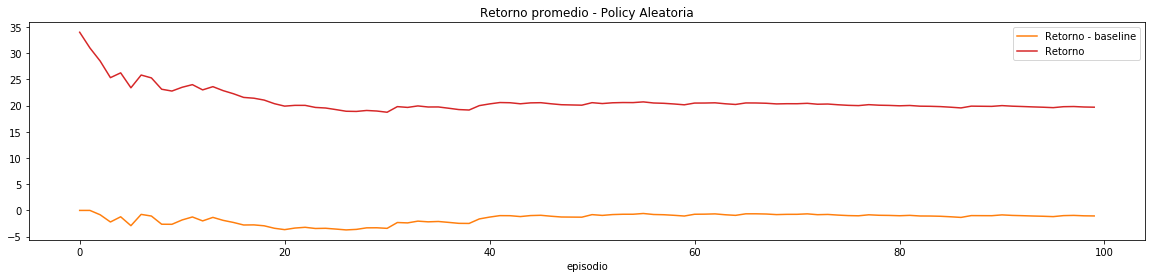

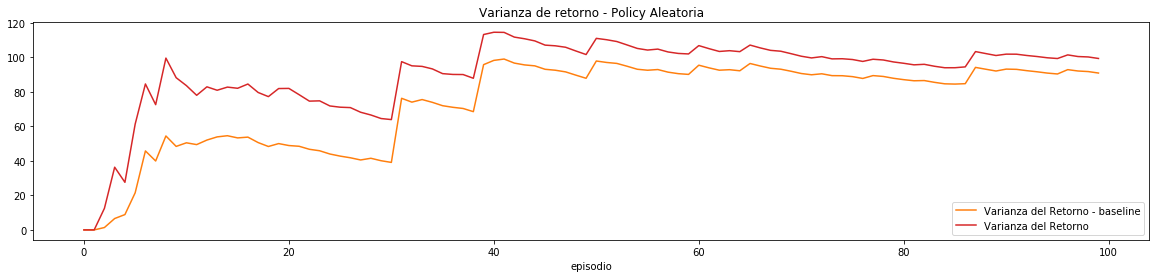

In [135]:
N=500
plt.figure(figsize=(20,4))
# plt.scatter(range(len(returns[:N])), returns[:N], c='C0')
plt.plot(estimated_V[:N], c='C1', label='Retorno - baseline')
plt.plot(run_mean[:N], c='C3', label='Retorno')
plt.title('Retorno promedio - Policy Aleatoria')
plt.xlabel('episodio')
plt.legend()
plt.show()
plt.figure(figsize=(20,4))
plt.plot(variance_V[:N],  c='C1', label='Varianza del Retorno - baseline')
plt.plot(run_var, c='C3', label='Varianza del Retorno')
plt.title('Varianza de retorno - Policy Aleatoria')
plt.xlabel('episodio')
plt.legend()
plt.show()

# Modelo entrenado

In [0]:
from keras.models import load_model

In [0]:
trained_model = load_model('/content/cartpole-trained.hdf5', compile=False)
# trained_model = load_model('/content/lunar-lander-trained.hdf5', compile=False)

In [93]:
# Puede tardar mas de 2 mins
%time estimated_V_trained, variance_V_trained, run_mean_trained, run_var_trained, returns_trained = monte_carlo(env, trained_model, seed=42, N=100)

Episodio: 99
CPU times: user 31.7 s, sys: 1.54 s, total: 33.2 s
Wall time: 27.1 s


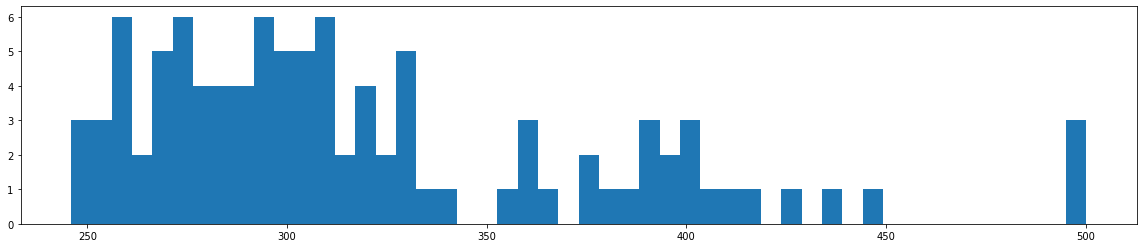

In [94]:
plt.figure(figsize=(20,4))
_ = plt.hist(returns_trained, 50)

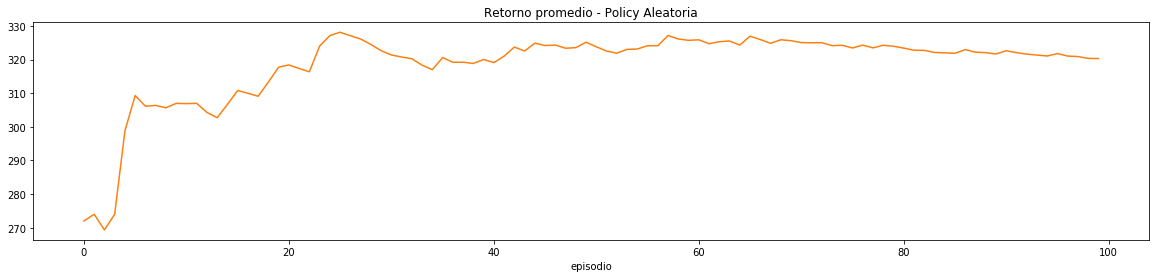

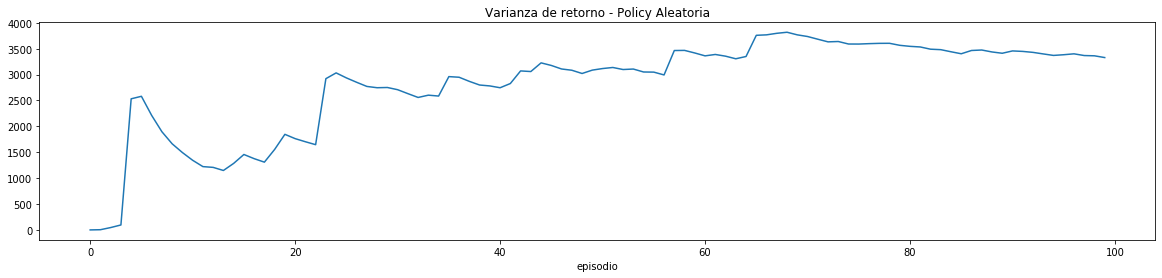

In [95]:
N=500
plt.figure(figsize=(20,4))
# plt.scatter(range(len(returns_trained[:N])), returns_trained[:N], c='C0')
plt.plot(estimated_V_trained[:N], c='C1')
plt.title('Retorno promedio - Policy Aleatoria')
plt.xlabel('episodio')
plt.show()
plt.figure(figsize=(20,4))
plt.plot(variance_V_trained[:N])
plt.title('Varianza de retorno - Policy Aleatoria')
plt.xlabel('episodio')
plt.show()

In [0]:
def monte_carlo_value_estimate(env, model, seed=42, N=500, explore=True):
  value_model = get_value_model(env, lr=0.01)
  returns = []
  predicted_v = []
  losses = []
  for i in range(N):
    observations, actions, rewards = run_episode(env, model, seed=seed, explore=explore)
    observations_np = np.array(observations)
    history = value_model.fit(observations_np, rewards, verbose=0, epochs=1)
    returns.append(np.sum(rewards))
    predicted_v.append(value_model.predict(observations_np).sum())
    loss = history.history['loss'][0]
    losses.append(loss)
    print(f'\rEpisodio: {i}, loss: {loss}', end='')
  print()
  returns = np.array(returns)
  estimated_V = np.cumsum(returns)/(np.array(range(len(returns)))+1) # mu = sum(xi)/N
  variance_V_i = (returns - estimated_V)**2
  variance_V = np.cumsum(variance_V_i)/(np.array(range(len(returns)))+1e-10) # var = sum(xi-mu)^2 / N

  differ = returns-np.array(predicted_v)
  estimated_model_V = np.cumsum(differ)/(np.array(range(len(differ)))+1)
  variance_V_i_model = (differ - estimated_model_V)**2
  variance_V_model = np.cumsum(variance_V_i_model)/(np.array(range(len(differ)))+1e-10) # var = sum(xi-mu)^2 / N
  return estimated_V, variance_V, returns, estimated_model_V, variance_V_model, losses

In [100]:
estimated_V, variance_V, returns, estimated_model_V, variance_V_model, losses = monte_carlo_value_estimate(env, model, N=500)

Episodio: 499, loss: 180.6432445929931


In [0]:
estimated_model_V.var(), estimated_V.var()

(54.93624130819688, 31.19049205923243)

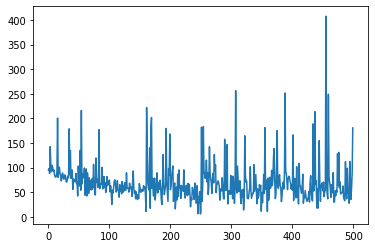

In [101]:
plt.plot(losses)

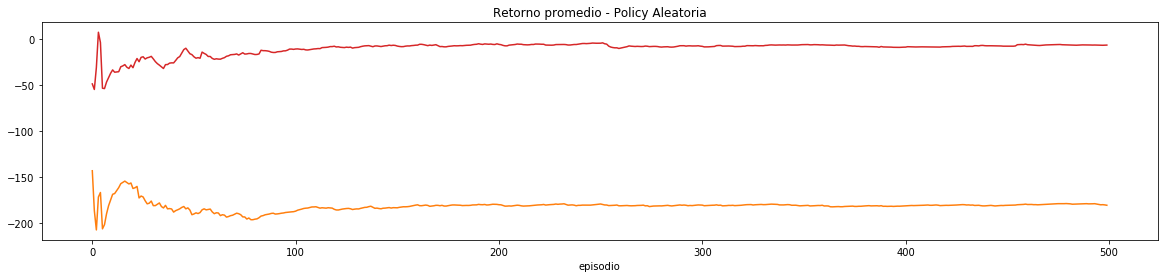

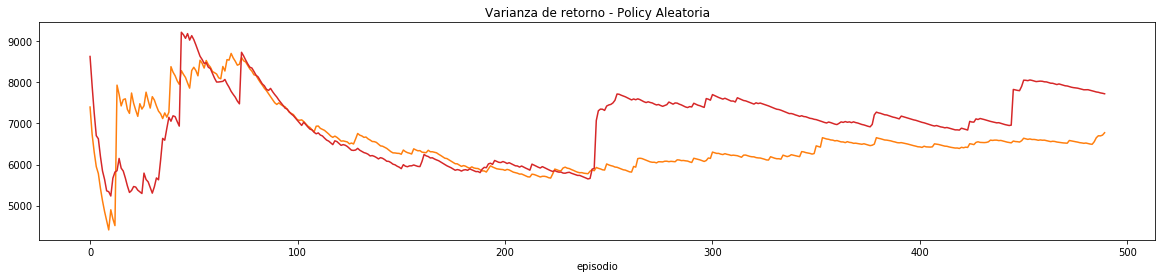

In [102]:
N=500
plt.figure(figsize=(20,4))
# plt.scatter(range(len(returns_trained[:N])), returns_trained[:N], c='C0')
plt.plot(estimated_V[:N], c='C1')
plt.plot(estimated_model_V[:N], c='C3')
plt.title('Retorno promedio - Policy Aleatoria')
plt.xlabel('episodio')
plt.show()
plt.figure(figsize=(20,4))
plt.plot(variance_V[10:N], c='C1')
plt.plot(variance_V_model[10:N], c='C3')
plt.title('Varianza de retorno - Policy Aleatoria')
plt.xlabel('episodio')
plt.show()